In [14]:
%matplotlib ipympl
import pickle
from typing import Iterable

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from simulate_dicke import sim_dicke


In [15]:
def plot_sim_dicke(
    N: int,
    T: float,
    n: int = 0,
    freq: float = 1.0,
    coup: float = 1.0,
    time_step=None,
    spin_state_name="excited",
):
    """
    Only for quick simulations.
    """
    tt, vt, et, duration = sim_dicke(
        N=N,
        T=T,
        n=n,
        freq=freq,
        coup=coup,
        time_step=time_step,
        spin_state_name=spin_state_name,
    )
    plt.scatter(tt, np.real_if_close(et[0]), s=10)
    plt.xlabel("t")
    plt.ylabel("$\\langle v(t), \\hat n v(t)\\rangle$")
    plt.title(f"N={N}")
    plt.show()

In [16]:
# with open("dicke_sim_09_01_2025-16_19_05_N-2-20_T-6.0.pickle", "rb") as file:
#     data = pickle.load(file)

with open(
    "dicke_sim_09_01_2025-17_04_45_excited_N-2-60_T-6.0.pickle", "rb"
) as file:
    data_excited = pickle.load(file)

with open(
    "dicke_sim_10_01_2025-14_46_06_superradiant_N-2-60_T-6.0.pickle", "rb"
) as file:
    data_superradient = pickle.load(file)

In [17]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


def slope(x1, y1, x2, y2) -> float:
    return (y2 - y1) / (x2 - x1)


def arr_slope(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    y1 = y[:-1]
    x1 = x[:-1]
    y2 = y[1:]
    x2 = x[1:]

    return slope(x1, y1, x2, y2)


def plot_data(
    data: list[dict],
    max_N: int = None,
    min_N: int = None,
    N_selection: Iterable = None,
    y: tuple = (None, None),
    x: tuple = (None, None),
    plot_slopes: bool = False,
):
    if plot_slopes:
        ys = np.array([np.real_if_close(res["st"][0]) for res in data])[::-1]
        xs = np.array([res["tt"][:-1] for res in data])[::-1]

    if not plot_slopes:
        ys = np.array([np.real_if_close(res["et"][0]) for res in data])[::-1]
        xs = np.array([res["tt"] for res in data])[::-1]
    Ns = np.array([res["N"] for res in data])[::-1]

    # if plot_slopes:
    #     # change to derivative approximation
    #     ys = np.array([arr_slope(x, y) for x, y in zip(xs, ys)])
    #     xs = np.array([x[:-1] for x in xs])

    min_x, max_x = x
    min_y, max_y = y

    if max_N is None:
        max_N = max(Ns)
    if min_N is None:
        min_N = min(Ns)

    # apriori filter for everything
    filter = np.logical_and(Ns <= max_N, min_N <= Ns)

    xs = xs[filter]
    ys = ys[filter]
    Ns = Ns[filter]

    fig, ax = plt.subplots()
    fig.set_layout_engine("constrained")
    w, h = fig.get_size_inches()
    aspectratio = h / w
    width = 8
    fig.set_size_inches(width, width * aspectratio, forward=False)

    # ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

    cmap = truncate_colormap(mpl.cm.viridis, 0.2, 0.92, len(ys))
    colors = cmap(np.linspace(0, 1, len(ys)))

    # a posterori filter just for the selection of graphs, colors are unaffected
    if N_selection is not None:
        selection_filter = np.isin(Ns, N_selection)
    if N_selection is None:
        selection_filter = np.ones_like(Ns)

    if plot_slopes:
        ax.axhline(y=0, xmin=0, xmax=1, color="black")

    for N, x, y, c, f in zip(Ns, xs, ys, colors, selection_filter):
        if f:
            ax.plot(
                x,
                y,
                "o",
                alpha=0.6,
                # linewidth=1.5,
                # markeredgewidth=1,
                markersize=2.5,
                label=f"N={N}",
                color=c,
            )
    ax.set_xlabel("t")
    ax.set_ylabel("$\\langle v(t), \\hat n v(t)\\rangle$")

    if max_y is not None and min_y is not None:
        ax.set_ylim(min_y, max_y)
    if max_x is not None and min_x is not None:
        ax.set_xlim(min_x, max_x)

    bounds = Ns
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        label="N",
        ax=ax,
        orientation="vertical",
        # ticks=Ns,
    )

    # always add highest N to ticks
    cbar_ticks = list(cbar.get_ticks())
    cbar_ticks.append(Ns[-1])
    if cbar_ticks[-1] - cbar_ticks[-2] <= 1:
        cbar_ticks.pop(-2)

    # filter ticks for selected graphs
    if N_selection is not None:
        cbar_ticks = N_selection

    cbar_ticks = np.array(cbar_ticks)

    cbar.set_ticks(cbar_ticks)
    return fig


In [18]:
# compute slopes and add to data
for data in [data_excited, data_superradient]:
    for res in data:
        res["st"] = list()
        for et in res["et"]:
            yt = np.real_if_close(np.array(et))
            xt = np.array(res["tt"])
            # change to derivative approximation
            slopes = arr_slope(xt, yt)
            res["st"].append(slopes)

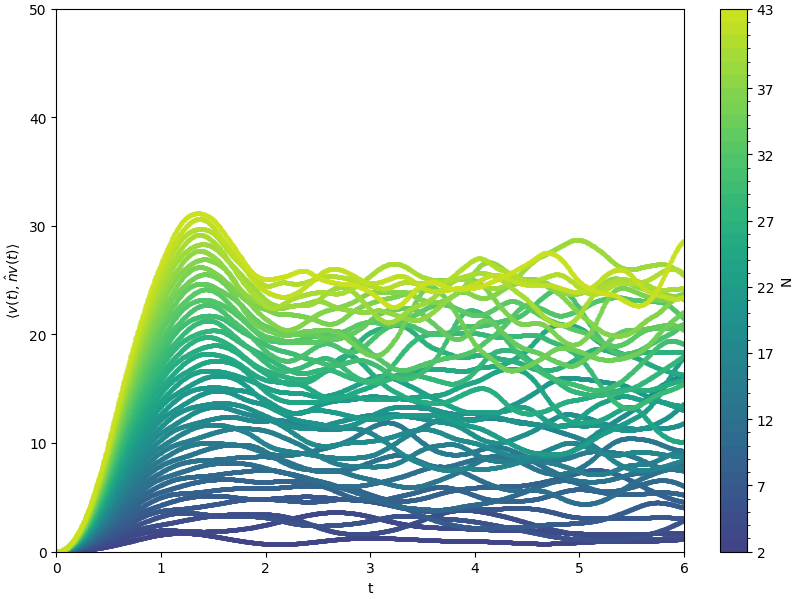

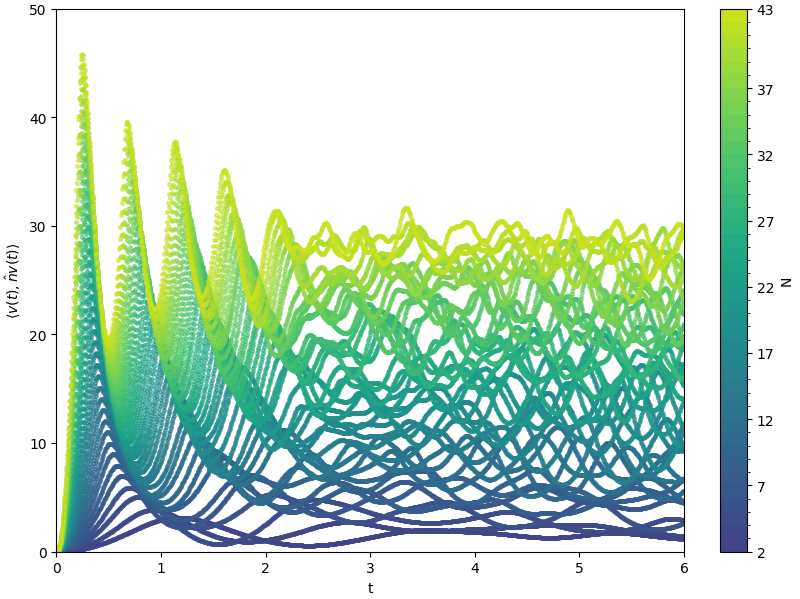

In [19]:
fig1 = plot_data(data_excited, max_N=43, x=(0, 6), y=(0, 50))
fig1s = plot_data(data_superradient, max_N=43, x=(0, 6), y=(0, 50))
# fig2 = plot_data(data_excited, max_N=43, x=(0, 3))
# fig3 = plot_data(data_excited, max_N=43, x=(0, 2))

- consider steepness of initial slope
- consider highpoint of initial slope
- consider average after initial slope


Above N=43 there are numerical artifacts. Possibly need to increase time_step


In [21]:
# compute slopes and add to data
for data in [data_excited, data_superradient]:
    for res in data:
        res["st_sign_change"] = list()
        for st in res["st"]:
            sign_slope = np.sign(res["st"][0])
            sign_change = np.sign(sign_slope[:-1] - sign_slope[1:])
            res["st_sign_change"].append(sign_change)

In [22]:
# compute average after first slope
for data in [data_excited, data_superradient]:
    for res in data:
        res["avg after first bump"] = list()
        for et, st, st_sign_change in zip(
            res["et"], res["st"], res["st_sign_change"]
        ):
            # get first non zero
            first_sign_change = (st_sign_change != 0).argmax(axis=0)
            after_first_bump = et[first_sign_change:]
            res["avg after first bump"].append(np.average(after_first_bump))

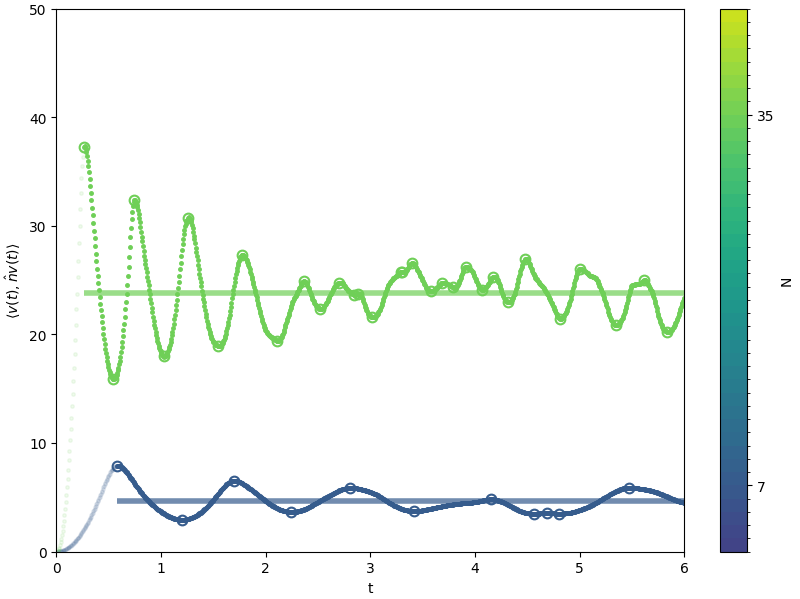

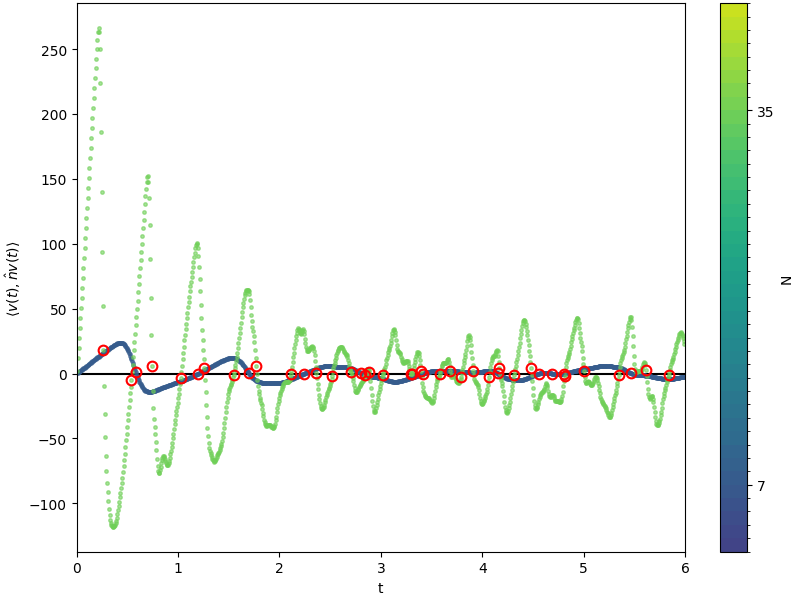

In [39]:
demonstration_selection = [7, 35]
fig_demo = plot_data(
    data_superradient,
    max_N=43,
    N_selection=demonstration_selection,
    x=(0, 6),
    y=(0, 50),
)

slopes_demos = plot_data(
    data_superradient,
    x=(0, 6),
    max_N=43,
    N_selection=demonstration_selection,
    plot_slopes=True,
)

for i, N in enumerate(demonstration_selection):
    res_demo = data_superradient[-(N - 1)]

    assert res_demo["N"] == N, f"{res_demo['N']},  {N}"

    sign_change = res_demo["st_sign_change"][0]

    filter = sign_change != 0

    axes = fig_demo.get_axes()
    ax = axes[0]

    first_sign_change = (sign_change != 0).argmax(axis=0)
    after_first_bump = res_demo["et"][0][first_sign_change:]
    t_after_first_bump = res_demo["tt"][first_sign_change:]

    lines = ax.get_lines()
    line = lines[i]
    line.set_alpha(0.1)
    color = line.get_color()

    ax.plot(
        t_after_first_bump,
        np.real_if_close(after_first_bump),
        "o",
        color=color,
        markersize=line.get_markersize(),
        markeredgewidth=line.get_markeredgewidth(),
    )

    ax.hlines(
        y=np.real_if_close(res_demo["avg after first bump"][0]),
        xmin=min(t_after_first_bump),
        xmax=max(t_after_first_bump),
        linewidths=4,
        alpha=0.7,
        colors=color,
        label=f"Average after initial slope for N={N}",
    )

    ax.plot(
        np.array(res_demo["tt"][:-2])[filter],
        np.real_if_close(np.array(res_demo["et"][0])[:-2][filter]),
        "o",
        markersize=7,
        markeredgewidth=1.5,
        markerfacecolor="none",
        color=color,
    )

    axes = slopes_demos.get_axes()
    ax = axes[0]
    ax.plot(
        np.array(res_demo["tt"][:-2])[filter],
        np.real_if_close(np.array(res_demo["st"][0])[:-1][filter]),
        "o",
        markersize=7,
        markeredgewidth=1.5,
        markerfacecolor="none",
        color="r",
    )